# Plant Seedlings Classification

## 1. Setup

In [51]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [52]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [53]:
# PATH = os.path.join('data', 'sample') + '/'
PATH = os.path.join('data') + '/'

In [54]:
ls {PATH}

sample/  sample_submission.csv.zip  test/  test.zip  train/  train.zip  valid/


If true, it means we will be able to utilize the GPU

In [7]:
torch.cuda.is_available()

True

If true, it means we will be able to utilize the GPU even better

In [8]:
torch.backends.cudnn.enabled

True

Since Mac keeps creating .DS_Store files I found a function for deleting it in the data directory.
Source: https://gist.github.com/mattsparks/19a0911999a623a3c302cc29c96b293a

In [97]:
def delete_ds_store():
    for root, dirs, files in os.walk(PATH):
        i = 0
        for file in files:
            if file.endswith('.DS_Store'):
                path = os.path.join(root, file)

                print("Deleting: %s" % (path))

                if os.remove(path):
                    print("Unable to delete!")
                else:
                    print("Deleted...")
                    i += 1

    print("Files Deleted: %d" % (i))


## 2. Exploratory analysis

### 2.1 Examining images

In [55]:
class_paths = glob(os.path.join(PATH, 'train', '*'))
class_names = [path.split('/')[-1] for path in class_paths]

Show two first images for each class to get the general idea how the data looks like.

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


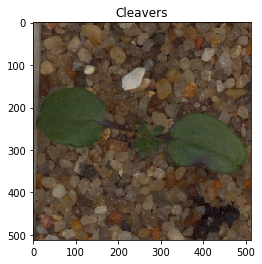

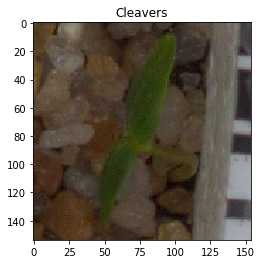

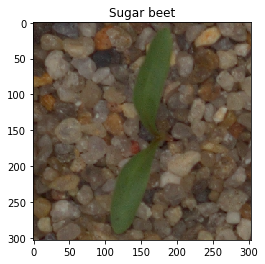

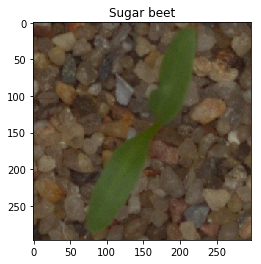

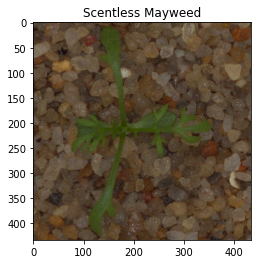

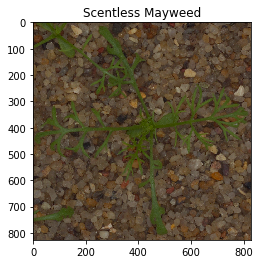

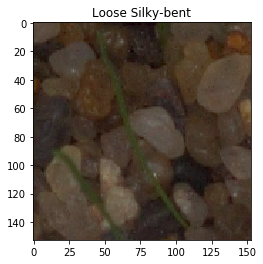

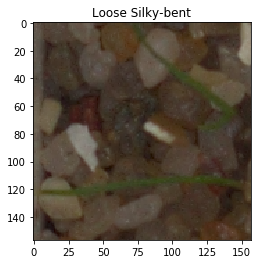

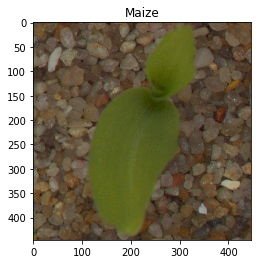

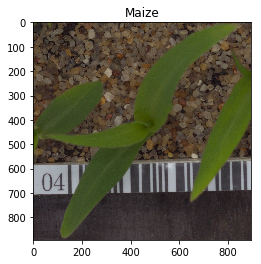

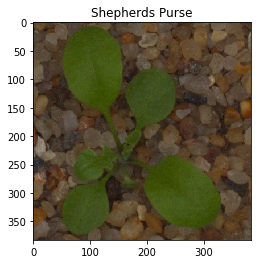

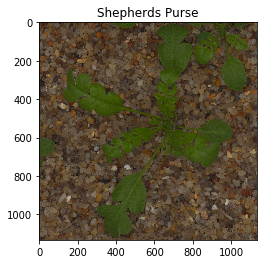

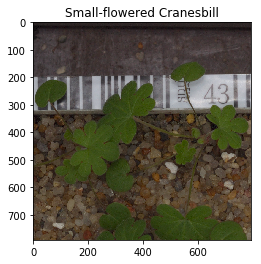

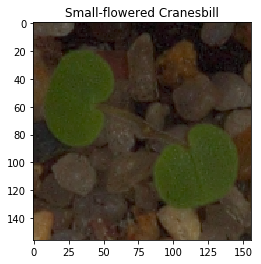

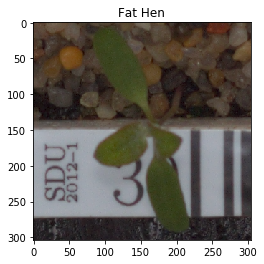

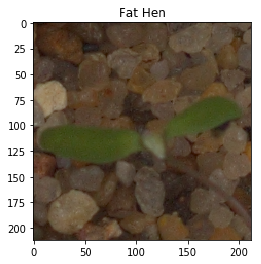

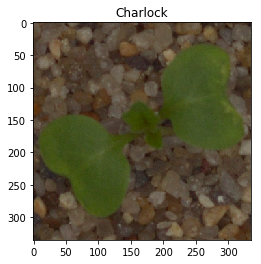

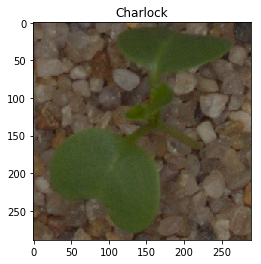

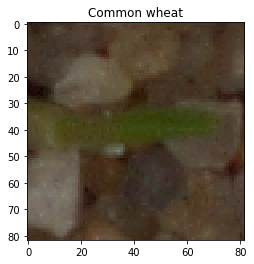

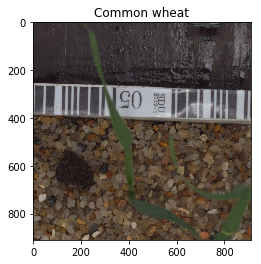

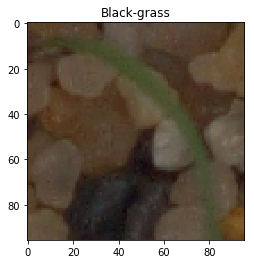

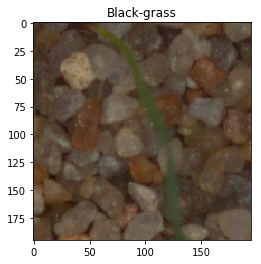

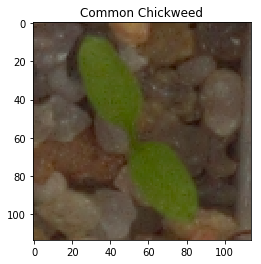

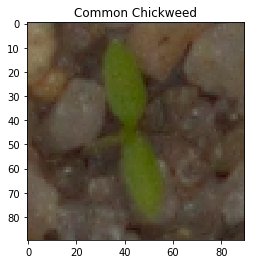

In [56]:
for class_name in class_names:
    files = glob(os.path.join(PATH, 'train', class_name)+'/*.png')
    for i in [0, 1]:
        img = plt.imread(files[i])
        plt.figure()
        plt.title(class_name)
        plt.imshow(img)

### 2.2 Image sizes

As we can see in the images above, they vary in size. 
Here I want to see how much.

In [57]:
raw_images = []
for class_name in class_names:
    files = glob(os.path.join(PATH, 'train', class_name)+'/*.png')
    for i in range(len(files)):
        raw_images.append(plt.imread(files[i]))
    files = glob(os.path.join(PATH, 'valid', class_name)+'/*.png')
    for i in range(len(files)):
        raw_images.append(plt.imread(files[i]))

Each element of the raw_images list is a 3D array.
First two dimensions are height and width, and the third one is the RGB value of the image.

Checking if all the pictures are squared

In [58]:
not_square = []
for image in raw_images:
    not_square.append(image.shape[0] != image.shape[1])

Number of not square pictures: 70


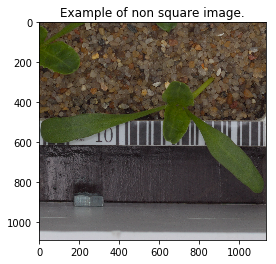

In [59]:
number_of_not_square = sum(not_square)
print ("Number of not square pictures:", number_of_not_square)
if number_of_not_square != 0:
    not_square_images = np.array(raw_images)[not_square]
    plt.title("Example of non square image.")
    plt.imshow(not_square_images[0])

Since part of the images are not squared, when analyzing the size of the pictures I will take into the account the higher value form width and height.

In [60]:
sizes_list = []
for image in raw_images:
    sizes_list.append(max(image.shape))

Min size: 49
Max size: 3991


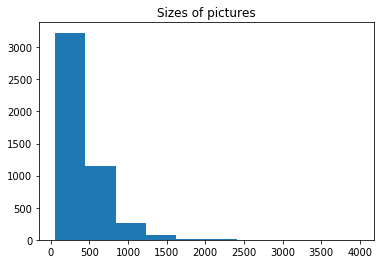

In [61]:
plt.title("Sizes of pictures")
plt.hist(sizes_list)
print("Min size:", min(sizes_list))
print("Max size:", max(sizes_list))

### 2.3 Conclusions

##### From the analysis so far, we can say that:
- Images vary in size (from 49 - 3991 pixels)
- All but 3 of the images are square
- Photos seem to be taken from the top

## 3. Preparing the model

In [126]:
size = 32

In [ ]:
delete_ds_store()

In [127]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, size), test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(4e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[0.      1.95669 1.52664 0.46469]                         
[1.      1.71404 1.48835 0.49491]                         


## 4. Examining the results

In [74]:
if 'sample' in PATH:
    visualization_size = 1
else:
    visualization_size = 4

In [75]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.amax(np.exp(log_preds),axis=1)

In [76]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], visualization_size, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)


In [77]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH + ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))


In [ ]:
%debug
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


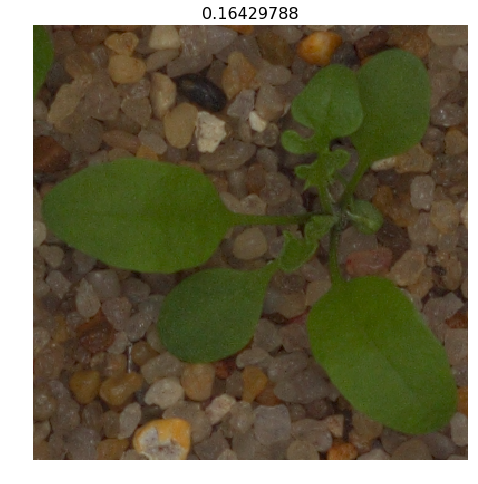

In [44]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [45]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)


In [ ]:
class_names = data.classes
for class_id in range(len(class_names)):
    print(class_names[class_id], class_id)
    plt.figure()
    plot_val_with_title(most_by_correct(class_id, True), "Most correct " + class_names[class_id])

In [ ]:
class_names = data.classes
for class_id in range(len(class_names)):
    print(class_names[class_id], class_id)
    plt.figure()
    plot_val_with_title(most_by_correct(class_id, False), "Most incorrect " + class_names[class_id])



## 5. Improving the model

### 5.1 Chosing the right learning rate

In [80]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [81]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 68%|██████▊   | 41/60 [00:01<00:00, 39.64it/s, loss=20.8]


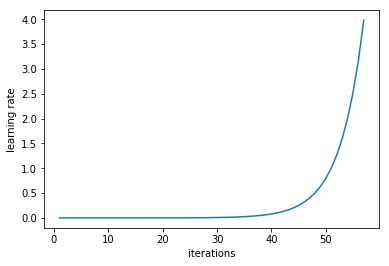

In [82]:
learn.sched.plot_lr()


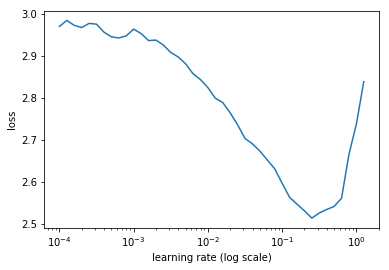

In [83]:
learn.sched.plot()


### 5.2 Data augmentation

In [128]:
tfms = tfms_from_model(resnet34, size, aug_tfms=transforms_top_down, max_zoom=1.1)

In [129]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [130]:
ims = np.stack([get_augs() for i in range(6)])


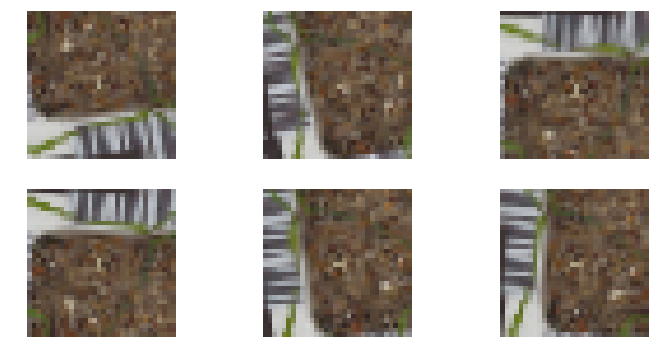

In [131]:
plots(ims, rows=2)

In [150]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=True)


In [151]:
learn.fit(2e-2, 20)

HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

[0.      1.89198 1.56431 0.45762]                         
[1.      1.6303  1.50583 0.48401]                         
[2.      1.49872 1.40392 0.50588]                         
[3.      1.40089 1.42126 0.53141]                         
[4.      1.3554  1.37263 0.53868]                         
[5.      1.31385 1.37998 0.52747]                         
[6.      1.2507  1.39049 0.52435]                         
  0%|          | 0/60 [00:00<?, ?it/s]


KeyboardInterrupt: 

### 5.3 Adding cycles

In [134]:
learn.precompute=False

In [135]:
learn.fit(2e-2, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      1.48142 1.27197 0.5762 ]                         
[1.      1.43175 1.26443 0.56397]                         
[2.      1.40453 1.24056 0.57516]                         
[3.      1.3635  1.25484 0.56656]                         
[4.      1.32413 1.21855 0.57567]                         
[5.      1.29785 1.22566 0.57255]                         
[6.      1.28152 1.21873 0.56916]                         



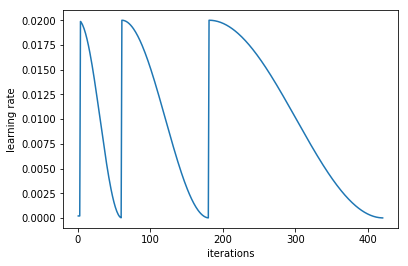

In [136]:
learn.sched.plot_lr()


In [137]:
learn.save('sec53_lastlayer')

In [138]:
learn.load('sec53_lastlayer')

### 5.4 Finetuning the network

In [152]:
learn.unfreeze()

In [153]:
learning_rate_base = 1e-2
lr=np.array([learning_rate_base/9,learning_rate_base/3,learning_rate_base])

In [154]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))


 98%|█████████▊| 59/60 [00:05<00:00, 11.70it/s, loss=1.5]
                                                         [0.      1.4998  1.30966 0.53348]

100%|██████████| 60/60 [00:05<00:00, 11.71it/s, loss=1.46]
                                                          [1.      1.45939 1.28334 0.5598 ]

 92%|█████████▏| 55/60 [00:05<00:00, 10.69it/s, loss=1.41]
                                                          [2.      1.4057  1.28277 0.54861]

 93%|█████████▎| 56/60 [00:05<00:00, 10.53it/s, loss=1.4]
                                                         [3.      1.40371 1.27955 0.55355]

 98%|█████████▊| 59/60 [00:04<00:00, 11.87it/s, loss=1.36]
                                                          [4.      1.36194 1.28359 0.5585 ]

 97%|█████████▋| 58/60 [00:05<00:00, 11.58it/s, loss=1.35]
                                                          [5.      1.35207 1.28255 0.55564]

 97%|█████████▋| 58/60 [00:05<00:00, 11.45it/s, loss=1.32]
                                

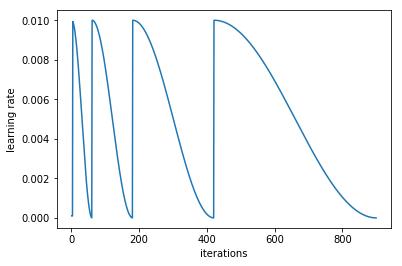

In [155]:
learn.sched.plot_lr()


In [156]:
learn.save('sec54_all')

In [157]:
log_preds,y = learn.TTA()
preds = np.argmax(log_preds, axis=1)
probs = np.mean(np.exp(log_preds), axis=0)


100%|██████████| 4/4 [00:07<00:00,  1.95s/it]
                                             

## 6. Analyzing results again

In [147]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)


[[ 11   0   0   0   1   1  38   0   1   0   0   0]
 [  0  72   3   0   0   0   0   0   0   0   3   0]
 [  0   1  50   1   0   1   0   0   2   0   2   0]
 [  0   0   0 117   0   0   0   0   0   4   0   1]
 [  4   1   0   0  32   1   4   0   0   0   0   2]
 [  0   2   0   0   0  86   2   0   1   0   1   3]
 [  5   0   0   2   0   5 117   0   1   0   0   0]
 [  0   0   0   4   0   1   0  36   0   0   1   2]
 [  1   0   0   2   0   1   0   0  98   1   0   0]
 [  0   0   0   4   0   0   0   0  17  23   2   0]
 [  0   0   0   0   0   0   0   0   0   1  98   0]
 [  0   0   0   0   1   6   1   1   3   0   1  64]]


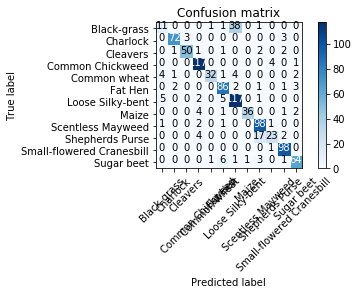

In [158]:
plot_confusion_matrix(cm, data.classes)


## 7. Making predictions for the test set

In [167]:
test_log_predictions, _ = learn.TTA(is_test=True)


100%|██████████| 4/4 [00:02<00:00,  1.91it/s]
                                             

In [168]:
test_predictions = np.argmax(test_log_predictions, axis=1)

In [174]:
test_predictions_classes = [data.classes[pred] for pred in test_predictions]

In [183]:
test_file_names = learn.data.test_ds.fnames

In [188]:
with open('submission.csv', 'w') as the_file:
    the_file.write('file,species\n')
    for file_path, prediction in zip(test_file_names, test_predictions_classes):
        file_name = file_path.split('/')[-1]
        the_file.write(file_name)
        the_file.write(",")
        the_file.write(prediction)
        the_file.write("\n")
the_file.close()

In [189]:
from IPython.display import FileLink
FileLink('submission.csv')


/home/paperspace/kaggle_plant_seedlings/submission.csv